# Reproducing The Best Results

### Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
!pip install lightly --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.5/745.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/HAR_WORK/HAR/

/content/drive/MyDrive/HAR_WORK/HAR


## Pretain.py

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from lightly.loss import SwaVLoss
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
import torch.nn.functional as F

# SwAV model
class SwaV(nn.Module):
    def __init__(self, backbone, n_prototypes):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(128, 128, 64)
        self.prototypes = SwaVPrototypes(64, n_prototypes=n_prototypes)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        p = self.prototypes(x)
        return p

# MLP backbone
class MLPBackbone(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super().__init__()
        layers = []
        for output_size in layer_sizes:
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
            input_size = output_size
        layers.append(nn.Linear(input_size, 128))  # Ensure the final output shape is compatible with projection head
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the input
        return self.model(x)

# Custom data augmentation for time series with multiple features
def augment_time_series(data):
    # Random time shift
    shift = np.random.randint(1, data.shape[1])
    shifted_data = np.roll(data, shift, axis=1)

    # Adding random noise
    noise = np.random.normal(0, 0.01, data.shape)
    noisy_data = data + noise

    # Scaling
    scale = np.random.uniform(0.8, 1.2)
    scaled_data = data * scale

    # Random permutation
    permuted_data = np.random.permutation(data.T).T

    # Choose a random augmentation
    augmented_data = random.choice([shifted_data, noisy_data, scaled_data, permuted_data])
    return augmented_data

# Subsampling function for low resolution
def subsample(data, factor=2):
    return data[:, ::factor]

# Custom dataset for multi-feature time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return torch.tensor(sample, dtype=torch.float32), 0

# Load data
path = './data_clean.npy'
data = np.load(path)

# Split data into train and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Custom dataloaders
train_dataset = TimeSeriesDataset(train_data, transform=augment_time_series)
val_dataset = TimeSeriesDataset(val_data)

batch_size = 128
dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=8
)

dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=8
)

# Function to train and evaluate model
def train_and_evaluate(layer_sizes, n_prototypes, lr, model_name):
    # Initialize SwAV model with MLP backbone
    input_size = 6 * data.shape[1]  # Assuming the input data shape is (batch_size, 6, time_steps)
    backbone = MLPBackbone(input_size, layer_sizes)
    model = SwaV(backbone, n_prototypes)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Loss function and optimizer
    criterion = SwaVLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Early stopping parameters
    patience = 10  # Number of epochs to wait for improvement
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Training and validation loop
    print(f"Starting Training for {model_name}")
    num_epochs = 200
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_train_loss = 0
        for batch in dataloader_train:
            views = batch[0].to(device)
            model.prototypes.normalize()

            # Generate high resolution views (original and augmented)
            high_resolution_views = [views, torch.tensor(augment_time_series(views.cpu().numpy()), dtype=torch.float32).to(device)]

            # Generate low resolution views (subsampled)
            low_resolution_views = [subsample(view.cpu().numpy()) for view in high_resolution_views]
            low_resolution_views = [torch.tensor(view, dtype=torch.float32).to(device) for view in low_resolution_views]

            # Apply bilinear upscaling
            low_resolution_views = [F.interpolate(view.unsqueeze(1), size=(views.size(1), views.size(2)), mode='bilinear').squeeze(1) for view in low_resolution_views]

            # Combine and permute to match expected input shape
            all_views = high_resolution_views + low_resolution_views
            all_views = [view.permute(0, 2, 1) for view in all_views]  # (batch_size, channels, time_steps)

            # Apply the model to the augmented views
            multi_crop_features = [model(view) for view in all_views]
            high_resolution = multi_crop_features[:2]
            low_resolution = multi_crop_features[2:]

            loss = criterion(high_resolution, low_resolution)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = total_train_loss / len(dataloader_train)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in dataloader_val:
                views = batch[0].to(device)
                model.prototypes.normalize()

                # Generate high resolution views (original and augmented)
                high_resolution_views = [views, torch.tensor(augment_time_series(views.cpu().numpy()), dtype=torch.float32).to(device)]

                # Generate low resolution views (subsampled)
                low_resolution_views = [subsample(view.cpu().numpy()) for view in high_resolution_views]
                low_resolution_views = [torch.tensor(view, dtype=torch.float32).to(device) for view in low_resolution_views]

                # Apply bilinear upscaling
                low_resolution_views = [F.interpolate(view.unsqueeze(1), size=(views.size(1), views.size(2)), mode='bilinear').squeeze(1) for view in low_resolution_views]

                # Combine and permute to match expected input shape
                all_views = high_resolution_views + low_resolution_views
                all_views = [view.permute(0, 2, 1) for view in all_views]  # (batch_size, channels, time_steps)

                # Apply the model to the augmented views
                multi_crop_features = [model(view) for view in all_views]
                high_resolution = multi_crop_features[:2]
                low_resolution = multi_crop_features[2:]

                loss = criterion(high_resolution, low_resolution)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(dataloader_val)
        val_losses.append(avg_val_loss)

        print(f"Epoch: {epoch:>02}, Train Loss: {avg_train_loss:.5f}, Validation Loss: {avg_val_loss:.5f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.5f}")
                break

    # Plotting the losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curve for {model_name}')
    plt.savefig(f'{model_name}_loss_curve.png')
    plt.close()

    # Save the model
    torch.save(backbone.state_dict(), f'{model_name}_backbone.pth')
    print(f'{model_name} saved successfully.')

# Define configurations
layer_sizes_list = [
    [768, 64, 32, 16],  # 3 hidden layers
    [768, 128, 64, 32],  # 3 hidden layers, different sizes
    [768, 256, 128, 64]  # 3 hidden layers, larger sizes
]

n_prototypes_list = [16, 32, 64]
lr_list = [0.001, 0.0001]

# Train and evaluate for each combination
for layer_sizes in layer_sizes_list:
    for n_prototypes in n_prototypes_list:
        for lr in lr_list:
            model_name = f'MLP_{layer_sizes[1]}_{layer_sizes[2]}_{layer_sizes[3]}_Prototypes_{n_prototypes}_LR_{lr}'
            train_and_evaluate(layer_sizes, n_prototypes, lr, model_name)


### Reload Trained Backbone

In [4]:
import torch
import torch.nn as nn

class MLPBackbone(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super().__init__()
        layers = []
        for output_size in layer_sizes:
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
            input_size = output_size
        layers.append(nn.Linear(input_size, 128))  # Ensure the final output shape is compatible with projection head
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the input
        return self.model(x)


# Parâmetros da arquitetura original
input_size = 6*60
layer_sizes = [768, 128, 64, 32]
# Carregar o modelo salvo
backbone = MLPBackbone(input_size, layer_sizes)
backbone.load_state_dict(torch.load('MLP_128_64_32_Prototypes_64_LR_0.0001_backbone.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone.eval()  # Defina o modelo para o modo de avaliação

MLPBackbone(
  (model): Sequential(
    (0): Linear(in_features=360, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=128, bias=True)
  )
)

In [ ]:
# Carregar os dados
data = np.load('./data_clean.npy')
model = MLPBackbone(input_size, layer_sizes)

In [ ]:
# Definição da Cabeça de Projeção (exemplo simples, ajuste conforme necessário)
class ProjectionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        return x

# Definição do Extrator de Features
class FeatureExtractor(nn.Module):
    def __init__(self, backbone, projection_head):
        super().__init__()
        self.backbone = backbone
        self.projection_head = projection_head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        return x

# Inicializar a cabeça de projeção
projection_head = ProjectionHead()

# Inicializar o extrator de features
feature_extractor = FeatureExtractor(model, projection_head).to('cpu')

# Preparar o dataset e o dataloader
class FullDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32)

full_dataset = FullDataset(data)
full_dataloader = DataLoader(
    full_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
)

# Extrair features
all_features = []
with torch.no_grad():
    for batch in full_dataloader:
        batch = batch.to('cpu').permute(0, 2, 1)  # Assegura a forma correta da entrada
        features = feature_extractor(batch)
        all_features.append(features.cpu().numpy())

# Concatenar todas as features
all_features = np.concatenate(all_features, axis=0)

# Agora `all_features` contém os vetores de features extraídos para todo o dataset

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.2 MB/s eta 0:00:00


In [10]:
from data_modules.har import HarDataModule

# Instantiating the HarDataModule with root dir at data/example
my_datamodule = HarDataModule(root_data_dir="data/har",
                              flatten = True,
                              target_column = "standard activity code",
                              batch_size=16)

In [11]:
import numpy as np

# Instanciando o HarDataModule
my_datamodule = HarDataModule(root_data_dir="data/har",
                              flatten=True,
                              target_column="standard activity code",
                              batch_size=16)

# Função para obter todos os dados e etiquetas de um DataLoader
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data.numpy())
        all_labels.append(labels.numpy())
    return np.vstack(all_data), np.concatenate(all_labels)

# Acessando os DataLoaders de treino e validação
train_loader = my_datamodule.train_dataloader()
val_loader = my_datamodule.val_dataloader()

# Obtendo todos os dados e etiquetas dos DataLoaders
X_train, y_train = get_all_data_and_labels(train_loader)
X_val, y_val = get_all_data_and_labels(val_loader)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (60, 360)
Shape of y_train: (60,)
Shape of X_val: (24, 360)
Shape of y_val: (24,)


In [12]:
train_dl = my_datamodule.train_dataloader()
val_dl = my_datamodule.val_dataloader()
test_dl = my_datamodule.test_dataloader()

In [13]:
# Parâmetros da arquitetura original
input_size = 6*60
layer_sizes = [768, 128, 64, 32]
num_classes = 6

Epoch 1/100, Train Loss: 1.6761271059513092, Train Accuracy: 0.4666666666666667, Val Loss: 1.5699293613433838, Val Accuracy: 0.3333333333333333
Epoch 2/100, Train Loss: 1.5830017924308777, Train Accuracy: 0.36666666666666664, Val Loss: 1.4771278500556946, Val Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.5113559663295746, Train Accuracy: 0.3333333333333333, Val Loss: 1.4140432476997375, Val Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.4997986257076263, Train Accuracy: 0.3333333333333333, Val Loss: 1.3659266233444214, Val Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.4594719111919403, Train Accuracy: 0.3333333333333333, Val Loss: 1.329603910446167, Val Accuracy: 0.3333333333333333
Epoch 6/100, Train Loss: 1.415280044078827, Train Accuracy: 0.3333333333333333, Val Loss: 1.3013753294944763, Val Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.3846130967140198, Train Accuracy: 0.3333333333333333, Val Loss: 1.2761209905147552, Val Accuracy: 0.375
Epoch 

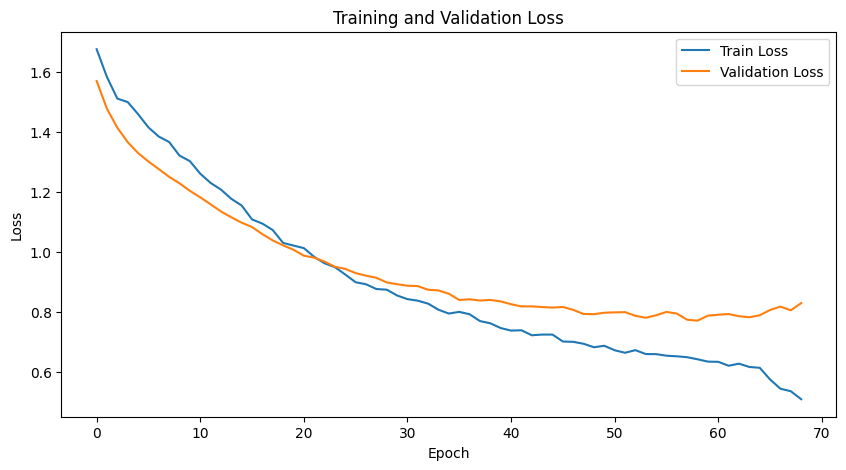

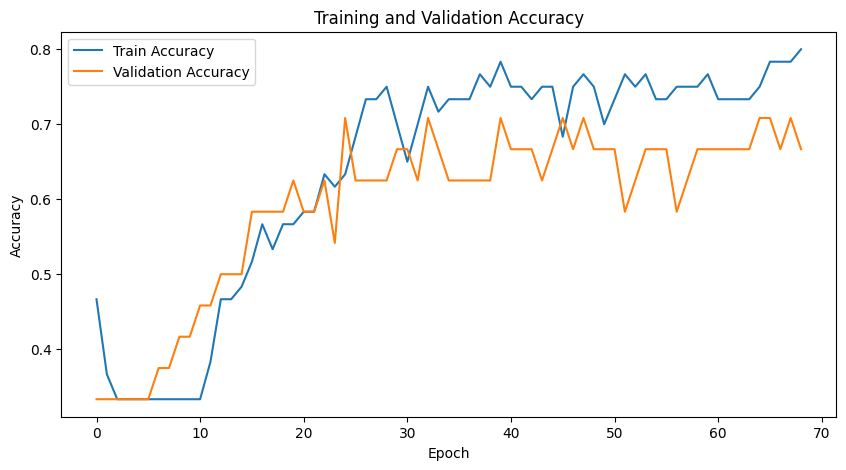

Test Loss: 0.7503, Test Accuracy: 0.6667


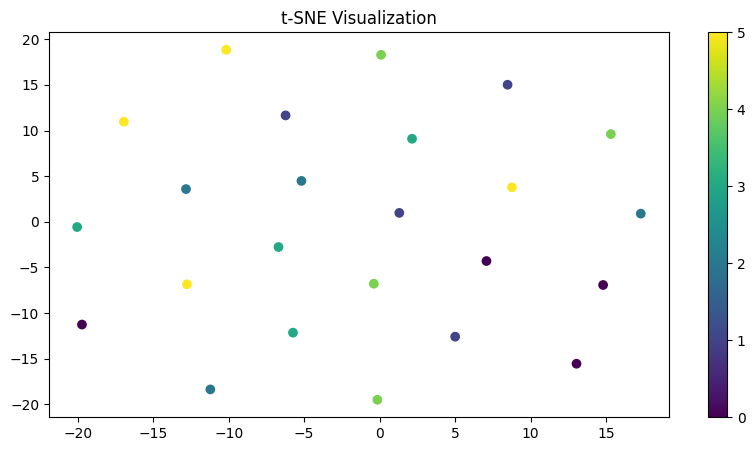

Configuration: MLP_128_64_32_Prototypes_64_LR_0.0001_backbone.pth with Validation Accuracy: 0.6667


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Função para definir a seed para reprodutibilidade
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_accuracy, _, _ = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
                model.load_state_dict(best_model_state)
                break

    return train_losses, val_losses, train_accuracies, val_accuracies
criterion = nn.CrossEntropyLoss()
# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return avg_loss, accuracy, all_preds, all_labels

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs, label = inputs.to(device), label.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label.cpu())
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Carregar o backbone pré-treinado
# config = 'MLP_128_64_32_Prototypes_64_LR_0.0001_backbone.pth'
# # backbone = MLPBackbone(input_size=360)  # Ajustar input_size para 360 conforme o erro indicado
# state_dict = torch.load(config, map_location=device)
# backbone.load_state_dict(state_dict)
# backbone.eval()

# Definir a cabeça de predição
head = MLPHead(input_size=128, num_classes=num_classes)
model = DownstreamModel(backbone=backbone, head=head)

# Congelar todas as camadas do backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Descongelar a cabeça do modelo
for param in model.head.parameters():
    param.requires_grad = True

# Definir otimizador
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# Treinamento do modelo
model.to(device)
num_epochs = 100
patience = 5
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dl, val_dl, criterion, optimizer, num_epochs, patience, device)

# Fine-tuning do melhor modelo
for param in model.backbone.parameters():
    param.requires_grad = True

# Definir otimizador para fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_fine_tuning_epochs = 5
fine_tuning_train_losses, fine_tuning_val_losses, fine_tuning_train_accuracies, fine_tuning_val_accuracies = train_model(
    model, train_dl, val_dl, criterion, optimizer, num_fine_tuning_epochs, patience, device
)

# Concatenar os resultados de treinamento e fine-tuning
train_losses += fine_tuning_train_losses
val_losses += fine_tuning_val_losses
train_accuracies += fine_tuning_train_accuracies
val_accuracies += fine_tuning_val_accuracies

# Plotar as perdas de treino e validação do modelo
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotar as acurácias de treino e validação do modelo
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Avaliação do modelo nos dados de teste
test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dl, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Extrair representações do modelo final
representations, labels = extract_representations(model, test_dl, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())

print(f'Configuration: {config} with Validation Accuracy: {test_accuracy:.4f}')


Test Loss: 0.7503, Test Accuracy: 0.6667


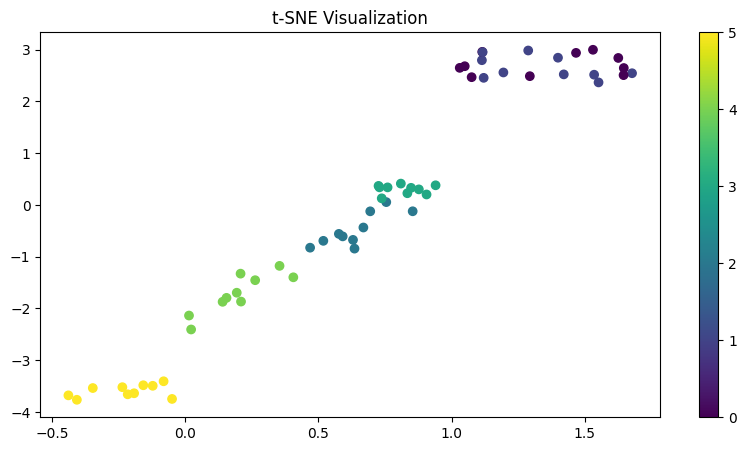

Configuration: MLP_128_64_32_Prototypes_64_LR_0.0001_backbone.pth with Test Accuracy: 0.6667


In [ ]:
# Avaliação do modelo nos dados de teste
test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dl, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Extrair representações do modelo final
representations, labels = extract_representations(model, train_dl, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())

print(f'Configuration: {config} with Test Accuracy: {test_accuracy:.4f}')

Epoch 1/100, Train Loss: 1.7176324129104614, Train Accuracy: 0.3, Val Loss: 1.6003947257995605, Val Accuracy: 0.4166666666666667
Epoch 2/100, Train Loss: 1.6197866201400757, Train Accuracy: 0.4, Val Loss: 1.478231966495514, Val Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.542535275220871, Train Accuracy: 0.3333333333333333, Val Loss: 1.4153639674186707, Val Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.4833848178386688, Train Accuracy: 0.3333333333333333, Val Loss: 1.3801981210708618, Val Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.4491194784641266, Train Accuracy: 0.3333333333333333, Val Loss: 1.3528480231761932, Val Accuracy: 0.3333333333333333
Epoch 6/100, Train Loss: 1.4483232498168945, Train Accuracy: 0.3333333333333333, Val Loss: 1.3308054506778717, Val Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.4074546098709106, Train Accuracy: 0.3333333333333333, Val Loss: 1.3072558641433716, Val Accuracy: 0.3333333333333333
Epoch 8/100, Train Loss:

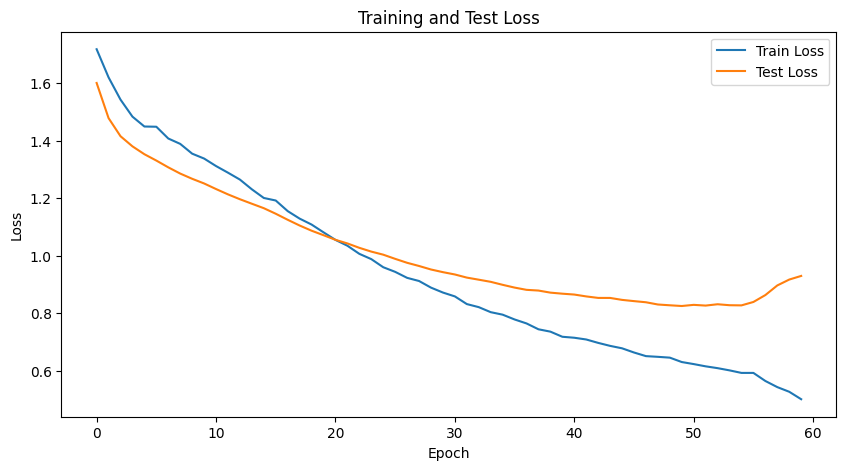

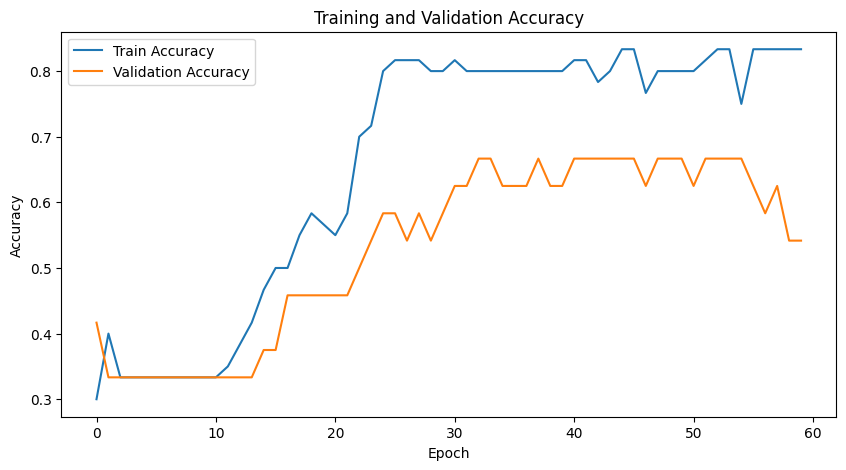

Test Loss: 0.8398, Test Accuracy: 0.6667


In [ ]:
## For Test
# Definir a cabeça de predição
head = MLPHead(input_size=128, num_classes=num_classes)
model = DownstreamModel(backbone=backbone, head=head)

# Congelar todas as camadas do backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Descongelar a cabeça do modelo
for param in model.head.parameters():
    param.requires_grad = True

# Definir otimizador
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# Treinamento do modelo
model.to(device)
num_epochs = 100
patience = 5
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, device)

# Fine-tuning do melhor modelo
for param in model.backbone.parameters():
    param.requires_grad = True

# Definir otimizador para fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_fine_tuning_epochs = 5
fine_tuning_train_losses, fine_tuning_val_losses, fine_tuning_train_accuracies, fine_tuning_val_accuracies = train_model(
    model, train_dl, val_dl, criterion, optimizer, num_fine_tuning_epochs, patience, device
)

# Concatenar os resultados de treinamento e fine-tuning
train_losses += fine_tuning_train_losses
val_losses += fine_tuning_val_losses
train_accuracies += fine_tuning_train_accuracies
val_accuracies += fine_tuning_val_accuracies

# Plotar as perdas de treino e validação do modelo
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Plotar as acurácias de treino e validação do modelo
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Avaliação do modelo nos dados de teste
test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dl, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

### Para poucas amostras

In [ ]:
# Particionando para [10%,20%,50%,70% e 100%] das amostras

### Para Dados de Validação

Epoch 1/100, Train Loss: 1.737898826599121, Train Accuracy: 0.5, Val Loss: 1.7020915746688843, Val Accuracy: 0.3333333333333333
Epoch 2/100, Train Loss: 1.6958709955215454, Train Accuracy: 0.5, Val Loss: 1.669369876384735, Val Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.6608262062072754, Train Accuracy: 0.5, Val Loss: 1.6429833769798279, Val Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.6297932863235474, Train Accuracy: 0.5, Val Loss: 1.6197842955589294, Val Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.6001304388046265, Train Accuracy: 0.5, Val Loss: 1.599379062652588, Val Accuracy: 0.3333333333333333
Epoch 6/100, Train Loss: 1.5731014013290405, Train Accuracy: 0.5, Val Loss: 1.582420289516449, Val Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.5500540733337402, Train Accuracy: 0.5, Val Loss: 1.5673661828041077, Val Accuracy: 0.3333333333333333
Epoch 8/100, Train Loss: 1.5283713340759277, Train Accuracy: 0.5, Val Loss: 1.5542925000190735, Val A

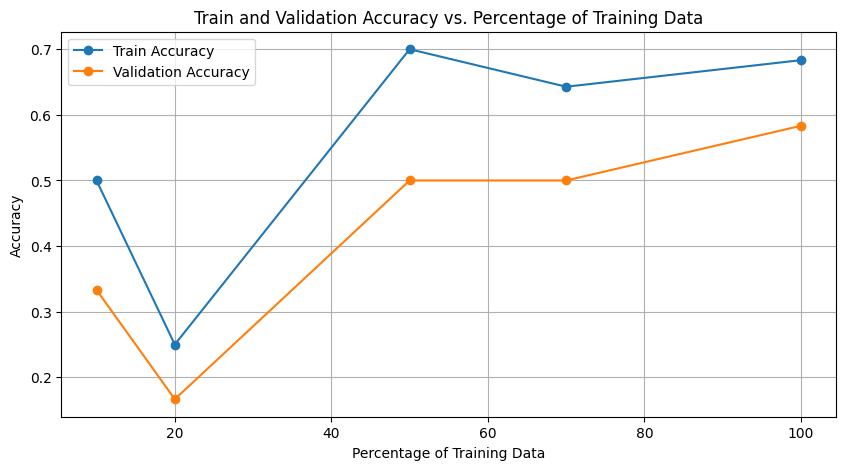

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Função para definir a seed para reprodutibilidade
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_accuracy, _, _ = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
                model.load_state_dict(best_model_state)
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return avg_loss, accuracy, all_preds, all_labels

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs, label = inputs.to(device), label.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label.cpu())
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Função para dividir os dados de treinamento
def get_subset_indices(dataset, percentage):
    subset_size = int(len(dataset) * percentage)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    return indices[:subset_size]

# Definir as porcentagens de dados de treinamento a serem usados
percentages = [0.1, 0.2, 0.5, 0.7, 1.0]

# Resultados para cada porcentagem
results = []

# Loop para treinar e avaliar o modelo em cada porcentagem
for percentage in percentages:
    # Obter índices dos subsets de dados de treinamento
    subset_indices = get_subset_indices(train_dl.dataset, percentage)
    train_subset = Subset(train_dl.dataset, subset_indices)
    train_loader = DataLoader(train_subset, batch_size=train_dl.batch_size, shuffle=True)

    # Carregar o backbone pré-treinado
    config = 'MLP_128_64_32_Prototypes_64_LR_0.0001_backbone.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = MLPBackbone(input_size=360, layer_sizes=[768, 128, 64, 32])  # Ajustar input_size para 360 conforme o erro indicado
    state_dict = torch.load(config, map_location=device)
    backbone.load_state_dict(state_dict)
    backbone.eval()

    # Definir a cabeça de predição
    head = MLPHead(input_size=128, num_classes=6)
    model = DownstreamModel(backbone=backbone, head=head)

    # Congelar todas as camadas do backbone
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Descongelar a cabeça do modelo
    for param in model.head.parameters():
        param.requires_grad = True

    # Definir otimizador
    optimizer = optim.Adam(model.head.parameters(), lr=0.001)

    # Treinamento do modelo
    num_epochs = 100
    patience = 5
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_dl, criterion, optimizer, num_epochs, patience, device)

    # Fine-tuning do melhor modelo
    for param in model.backbone.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    num_fine_tuning_epochs = 5
    fine_tuning_train_losses, fine_tuning_val_losses, fine_tuning_train_accuracies, fine_tuning_val_accuracies = train_model(
        model, train_loader, val_dl, criterion, optimizer, num_fine_tuning_epochs, patience, device
    )

    # Concatenar os resultados de treinamento e fine-tuning
    train_losses += fine_tuning_train_losses
    val_losses += fine_tuning_val_losses
    train_accuracies += fine_tuning_train_accuracies
    val_accuracies += fine_tuning_val_accuracies

    results.append((percentage, train_accuracies[-1], val_accuracies[-1]))
# Plotar as acurácias finais de cada porcentagem de dados de treinamento
percentages, train_accuracies, val_accuracies = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(np.array(percentages) * 100, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(np.array(percentages) * 100, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Percentage of Training Data')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs. Percentage of Training Data')
plt.legend()
plt.grid(True)
plt.show()

Percentages: (0.1, 0.2, 0.5, 0.7, 1.0)
Train Accuracies: (0.5, 0.25, 0.7, 0.6428571428571429, 0.6833333333333333)
Test Accuracies: (0.3333333333333333, 0.16666666666666666, 0.4583333333333333, 0.625, 0.5416666666666666)


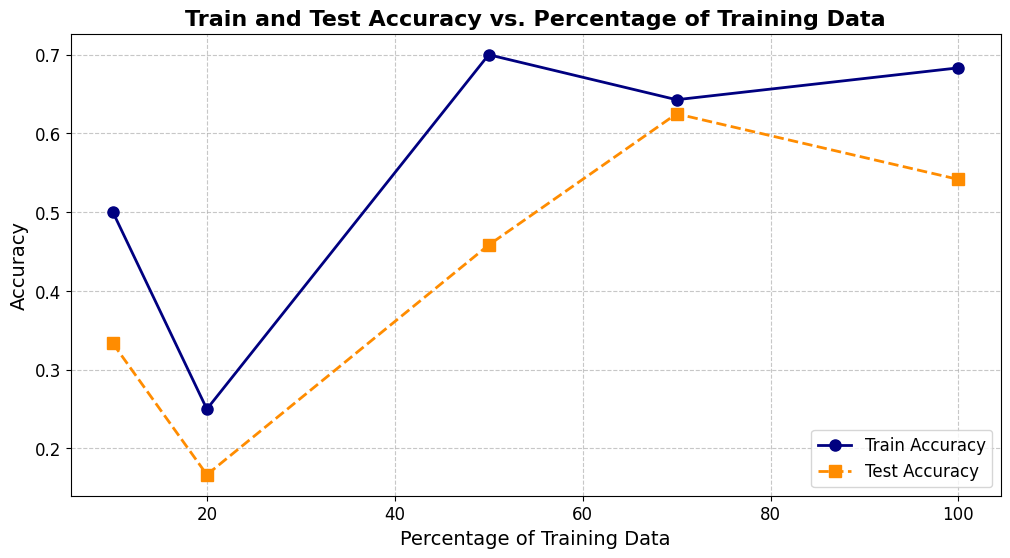

In [33]:
# Verificar se os dados estão corretos
print("Percentages:", percentages)
print("Train Accuracies:", train_accuracies)
print("Test Accuracies:", test_accuracies)

# Estilizar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(np.array(percentages) * 100, train_accuracies, marker='o', linestyle='-', color='navy', label='Train Accuracy', linewidth=2, markersize=8)
plt.plot(np.array(percentages) * 100, test_accuracies, marker='s', linestyle='--', color='darkorange', label='Test Accuracy', linewidth=2, markersize=8)

# Adicionar rótulos e título
plt.xlabel('Percentage of Training Data', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Train and Test Accuracy vs. Percentage of Training Data', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# Estilizar os eixos
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Para Dados de Teste

In [36]:

seed = 42
set_seed(seed)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        test_loss, test_accuracy, _, _ = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best test loss: {best_test_loss:.4f}")
                model.load_state_dict(best_model_state)
                break

    return train_losses, test_losses, train_accuracies, test_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return avg_loss, accuracy, all_preds, all_labels

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs, label = inputs.to(device), label.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label.cpu())
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Função para dividir os dados de treinamento
def get_subset_indices(dataset, percentage):
    subset_size = int(len(dataset) * percentage)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    return indices[:subset_size]

# Definir as porcentagens de dados de treinamento a serem usados
percentages = [0.1, 0.2, 0.5, 0.7, 1.0]

# Resultados para cada porcentagem
results = []

# Loop para treinar e avaliar o modelo em cada porcentagem
for percentage in percentages:
    # Obter índices dos subsets de dados de treinamento
    subset_indices = get_subset_indices(train_dl.dataset, percentage)
    train_subset = Subset(train_dl.dataset, subset_indices)
    train_loader = DataLoader(train_subset, batch_size=train_dl.batch_size, shuffle=True)

    # Carregar o backbone pré-treinado
    config = 'MLP_128_64_32_Prototypes_64_LR_0.0001_backbone.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = MLPBackbone(input_size=360, layer_sizes=[768, 128, 64, 32])  # Ajustar input_size para 360 conforme o erro indicado
    state_dict = torch.load(config, map_location=device)
    backbone.load_state_dict(state_dict)
    backbone.eval()

    # Definir a cabeça de predição
    head = MLPHead(input_size=128, num_classes=6)
    model = DownstreamModel(backbone=backbone, head=head)

    # Congelar todas as camadas do backbone
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Descongelar a cabeça do modelo
    for param in model.head.parameters():
        param.requires_grad = True

    # Definir otimizador
    optimizer = optim.Adam(model.head.parameters(), lr=0.001)

    # Treinamento do modelo
    num_epochs = 100
    patience = 5
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_dl, criterion, optimizer, num_epochs, patience, device)

    # Fine-tuning do melhor modelo
    for param in model.backbone.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    num_fine_tuning_epochs = 5
    fine_tuning_train_losses, fine_tuning_test_losses, fine_tuning_train_accuracies, fine_tuning_test_accuracies = train_model(
        model, train_loader, test_dl, criterion, optimizer, num_fine_tuning_epochs, patience, device
    )

    # Concatenar os resultados de treinamento e fine-tuning
    train_losses += fine_tuning_train_losses
    test_losses += fine_tuning_test_losses
    train_accuracies += fine_tuning_train_accuracies
    test_accuracies += fine_tuning_test_accuracies

    # Avaliação do modelo nos dados de teste
    test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dl, criterion, device)
    print(f'Percentage: {percentage * 100}% - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    results.append((percentage, train_accuracies[-1], test_accuracies[-1]))

# Plotar as acurácias finais de cada porcentagem de dados de treinamento
percentages, train_accuracies, test_accuracies = zip(*results)
# plt.figure(figsize=(10, 5))
# plt.plot(np.array(percentages) * 100, train_accuracies, marker='o', label='Train Accuracy')
# plt.plot(np.array(percentages) * 100, test_accuracies, marker='o', label='Test Accuracy')
# plt.xlabel('Percentage of Training Data')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Percentage of Training Data')
# plt.legend()
# plt.grid(True)
# plt.show()


Epoch 1/100, Train Loss: 1.737898826599121, Train Accuracy: 0.5, Test Loss: 1.6994572877883911, Test Accuracy: 0.3333333333333333
Epoch 2/100, Train Loss: 1.6958709955215454, Train Accuracy: 0.5, Test Loss: 1.6659294366836548, Test Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.6608262062072754, Train Accuracy: 0.5, Test Loss: 1.6397273540496826, Test Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.6297932863235474, Train Accuracy: 0.5, Test Loss: 1.6176761984825134, Test Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.6001304388046265, Train Accuracy: 0.5, Test Loss: 1.5990772247314453, Test Accuracy: 0.3333333333333333
Epoch 6/100, Train Loss: 1.5731014013290405, Train Accuracy: 0.5, Test Loss: 1.5852827429771423, Test Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.5500540733337402, Train Accuracy: 0.5, Test Loss: 1.5731235146522522, Test Accuracy: 0.3333333333333333
Epoch 8/100, Train Loss: 1.5283713340759277, Train Accuracy: 0.5, Test Loss: 1.56339

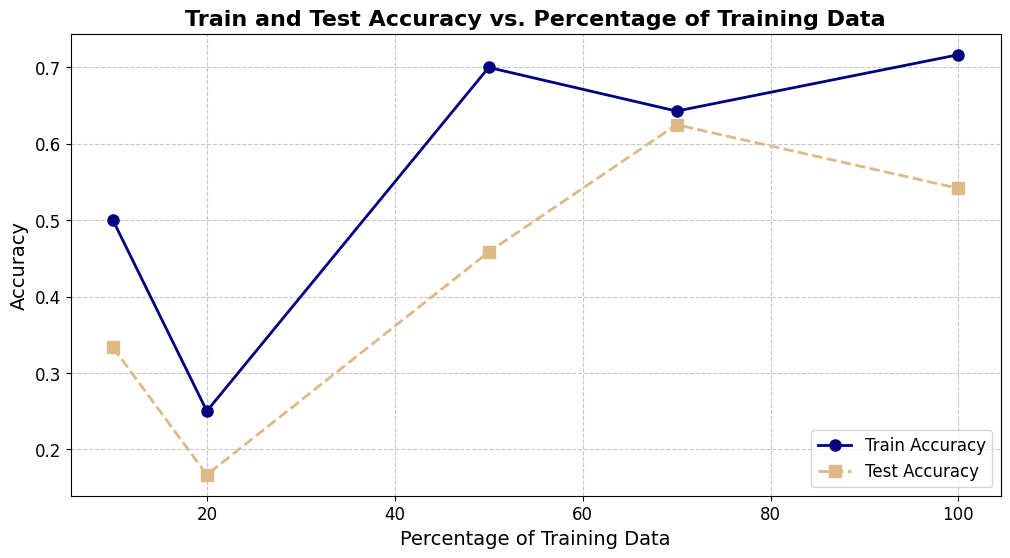

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(percentages) * 100, train_accuracies, marker='o', linestyle='-', color='navy', label='Train Accuracy', linewidth=2, markersize=8)
plt.plot(np.array(percentages) * 100, test_accuracies, marker='s', linestyle='--', color='burlywood', label='Test Accuracy', linewidth=2, markersize=8)
plt.xlabel('Percentage of Training Data', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Train and Test Accuracy vs. Percentage of Training Data', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()